In [1]:
from contextlib import contextmanager

from sympy import *
from sympy.abc import n, i, N, x, lamda, phi, z, m, j, r

init_printing()

In [2]:
@contextmanager
def lift_to_indexed(*syms):
    yield map(IndexedBase, map(latex, syms))
    
@contextmanager
def lift_to_Lambda(eq, return_eq=False):
    yield Lambda(eq.lhs.args, eq if return_eq else eq.rhs)

In [3]:
phi_abstract_coefficient = IndexedBase(r'\phi')

def Phi_poly_ctor(deg, z=Symbol('z'), i=Symbol('i'), j=Symbol('j')):
    k = symbols('k')
    Phi = Function(r'\Phi')
    terms = Sum(phi_abstract_coefficient[i, j, deg-k] * z**k, (k, 0, deg)).doit()
    return Eq(Phi(z, i, j), terms)


In [4]:
m = 2 # degree of \Xi minimal polynomial

In [5]:
Phi_poly = Phi_poly_ctor(deg=m-1)
Phi_poly

In [6]:
with lift_to_Lambda(Phi_poly) as Phi_fn:
    pass

Phi_fn, Phi_fn(z, 3, j)

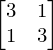

In [7]:
m = Matrix([
        [3, 1],
        [1, 3]
    ])
m

In [9]:
lamda_indexed = IndexedBase(r'\lambda')
mul_indexed = IndexedBase(r'm')

def eigen_data(matrix):
    eigenvals = {}
    multiplicities = {}
    data = {}
    for i, (eigen_value, multiplicity) in enumerate(matrix.eigenvals().items(), start=1):
        eigenvals[lamda_indexed[i]] = eigen_value
        multiplicities[mul_indexed[i]] = multiplicity
        data[i] = lamda_indexed[i], mul_indexed[i]
    return data, eigenvals, multiplicities

In [10]:
data, eigenvals, multiplicities = eigendata = eigen_data(m)
eigendata

In [11]:
def Phi_poly_define(Phi_poly, eigendata):
    
    data, eigenvals, multiplicities = eigendata
    z, *rest = Phi_poly.lhs.args
    
    def maker(i, j, verbose_return=False):
        Phi_def, delta = Function(r'\Phi_{{ {}, {} }}'.format(i, j)), Function(r'\delta')

        with lift_to_Lambda(Phi_poly) as Phi: 
            Phi_poly_ij = Phi(z, i, j)

        eqs = set()
        for l, (lamda_l, m_l) in data.items():
            derivatives = [(r, Eq(delta(z), Phi_poly_ij.diff(z, r-1))) for r in range(1, multiplicities[m_l]+1)]
            for r, der in derivatives:
                with lift_to_Lambda(der) as der_fn:
                    eqs.add(Eq(der_fn(lamda_l), KroneckerDelta(l, i)*KroneckerDelta(r, j)))

        respect_to = [phi_abstract_coefficient[i,j,k] for k in range(poly(Phi_poly_ij, z).degree()+1)]
        sols = solve(eqs, respect_to)

        lhs = Phi_def(z)
        rhs = Phi_poly_ij.subs(sols, simultaneous=True).collect(z)
        baked_poly = Eq(lhs, rhs)
        return (baked_poly, Eq(lhs, Phi_poly_ij), derivatives, eqs, sols) if verbose_return else baked_poly
    
    return maker
        

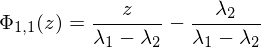

In [12]:
make = Phi_poly_define(Phi_poly, eigendata)
make(i=1, j=1,)

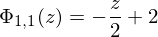

In [13]:
_.subs(eigenvals)

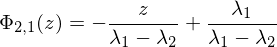

In [14]:
make = Phi_poly_define(Phi_poly, eigendata)
make(i=2, j=1,)

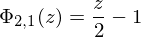

In [15]:
_.subs(eigenvals)

In [16]:
def component_polynomials(Phi_poly, eigendata):
    
    make = Phi_poly_define(Phi_poly, eigendata)
    data, eigenvals, multiplicities = eigendata
    polynomials = {(i, j): make(i, j) 
                   for i, (lamda, mul) in data.items()
                   for j in range(1, multiplicities[mul]+1)}

    return polynomials

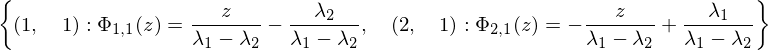

In [17]:
Phi_polynomials = component_polynomials(Phi_poly, eigendata)
Phi_polynomials

In [18]:
def g_poly(f_eq, eigendata, Phi_polys, matrix_form=False):
    
    data, eigenvals, multiplicities = eigendata
    delta, g = Function(r'\delta'), Function('g')
    Z = IndexedBase('Z')
    z, *rest = f_eq.lhs.args
    
    g_poly = Integer(0)
    
    for i, (lamda, mul) in data.items():
        for j in range(1, multiplicities[mul]+1):
            with lift_to_Lambda(f_eq) as f_fn,\
                 lift_to_Lambda(Eq(delta(z), f_fn(z).diff(z, j-1))) as der_fn,\
                 lift_to_Lambda(Phi_polys[i, j]) as Phi:
                    derivative_term = der_fn(lamda)
                    Phi_term = Z[i,j] if matrix_form else Phi(z)
                    g_poly += derivative_term*Phi_term
    
    return Eq(g(z), g_poly.expand().collect(z))

In [19]:
f, h = Function('f'), Function('h')
function_eq = Eq(f(z), h(z))
function_eq

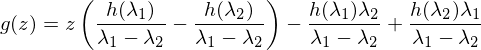

In [20]:
g = g_poly(function_eq, eigendata, Phi_polynomials)
g

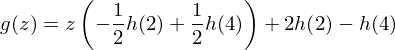

In [21]:
t = _.subs(eigenvals)
t

In [22]:
@contextmanager
def lift_to_matrix_function(f_def):
    
    def lift(matrix, post=lambda c: c.simplify()):
       
        z, *rest = f_def.lhs.args
        gpp, *_ = poly_from_expr(f_def.rhs, z)

        I = eye(matrix.rows)
        Z = f_def.rhs.coeff(z, gpp.degree())*I

        for d in range(gpp.degree()-1, -1, -1): Z = Z*matrix + f_def.rhs.coeff(z, d)*I

        return Z.applyfunc(post) if callable(post) else Z

    yield lift

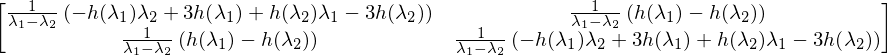

In [23]:
with lift_to_matrix_function(g) as g_fn:
    res = g_fn(m)

res

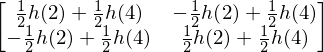

In [24]:
res.subs(eigenvals)

In [25]:
def component_matrices(matrix, Phi_polys):

    Z_matrices = {}
    
    for (i, j), cp in Phi_polys.items():
        with lift_to_matrix_function(cp) as cp_fn:
            Z_matrices[i, j] = cp_fn(matrix)
    
    return Z_matrices

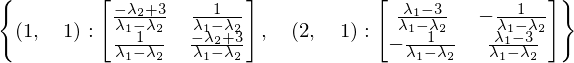

In [26]:
cmatrices = component_matrices(m, Phi_polynomials)
cmatrices

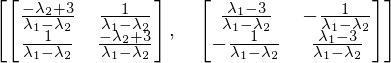

In [27]:
Zi1 = list(cm.as_immutable() for (i, j), cm in cmatrices.items() if j == 1)
Zi1

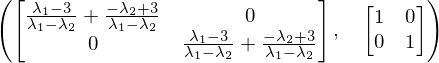

In [28]:
s = zeros(m.rows)
for Z in Zi1:
    s += Z
s, s.subs(eigenvals)

### `const`

In [101]:
fn = Eq(f(z), r)
fn

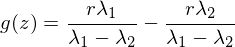

In [102]:
g = g_poly(fn, eigendata, Phi_polynomials)
g

In [103]:
g = g.subs(eigenvals)
g

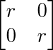

In [105]:
with lift_to_matrix_function(g) as g_const:
    m_const = g_const(m)
m_const

### `identity`

In [42]:
fn = Eq(f(z), z)
fn

In [43]:
g = g_poly(fn, eigendata, Phi_polynomials, matrix_form=True)
g

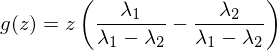

In [44]:
g = g_poly(fn, eigendata, Phi_polynomials, matrix_form=False)
g

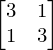

In [45]:
with lift_to_matrix_function(g) as g_identity:
    m_identity = g_identity(m)
m_identity

In [46]:
g = g.subs(eigenvals)
g

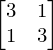

In [47]:
with lift_to_matrix_function(g) as g_sqrt:
    m_sqrt = g_sqrt(m)
m_sqrt

### `sqrt`

In [92]:
fn = Eq(f(z), sqrt(z))
fn

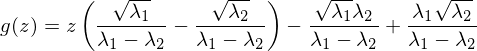

In [93]:
g = g_poly(fn, eigendata, Phi_polynomials)
g

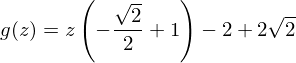

In [94]:
g = g.subs(eigenvals)
g

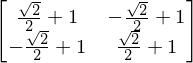

In [95]:
with lift_to_matrix_function(g) as g_sqrt:
    m_sqrt = g_sqrt(m)
m_sqrt

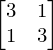

In [98]:
(m_sqrt**2).applyfunc(simplify)

### `power`

In [54]:
fn = Eq(f(z), z**r)
fn

In [55]:
g = g_poly(fn, eigendata, Phi_polynomials, matrix_form=True)
g

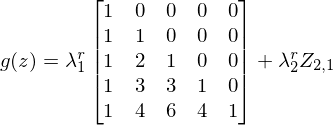

In [56]:
Z = IndexedBase('Z')
g.subs({Z[1,1]:Matrix(5,5, binomial)})

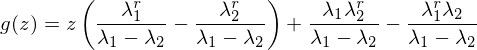

In [57]:
g = g_poly(fn, eigendata, Phi_polynomials)
g

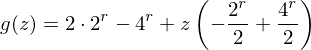

In [58]:
g = g.subs(eigenvals)
g

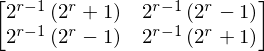

In [66]:
with lift_to_matrix_function(g) as g_power:
    m_power = g_power(m)
m_power

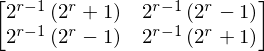

In [67]:
(m**r).applyfunc(simplify)

In [64]:
%%timeit
with lift_to_matrix_function(g) as g_power:
    m_power = g_power(m)
m_power

10 loops, best of 3: 58.3 ms per loop


In [65]:
%%timeit
(m**r).applyfunc(simplify)

10 loops, best of 3: 65 ms per loop


### `log`

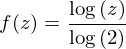

In [73]:
fn = Eq(f(z), log(z, 2))
fn

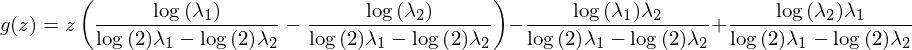

In [74]:
g = g_poly(fn, eigendata, Phi_polynomials)
g

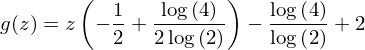

In [75]:
g = g.subs(eigenvals)
g

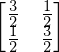

In [76]:
with lift_to_matrix_function(g) as g_log2:
    m_log2 = g_log2(m)
m_log2

### `inverse`

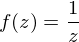

In [77]:
fn = Eq(f(z), 1/z)
fn

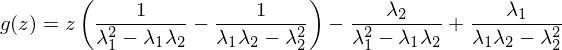

In [84]:
g = g_poly(fn, eigendata, Phi_polynomials)
g

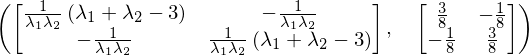

In [85]:
with lift_to_matrix_function(g) as g_inverse:
    m_inverse = g_inverse(m)

m_inverse, m_inverse.subs(eigenvals)

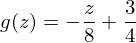

In [86]:
g = g.subs(eigenvals)
g

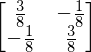

In [87]:
with lift_to_matrix_function(g) as g_inverse:
    m_inverse = g_inverse(m)
m_inverse

### `expt`

In [88]:
fn = Eq(f(z), exp(z))
fn

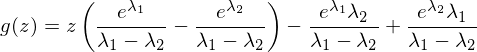

In [89]:
g = g_poly(fn, eigendata, Phi_polynomials)
g

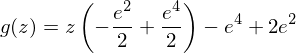

In [90]:
g = g.subs(eigenvals)
g

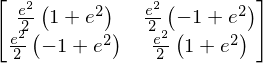

In [91]:
with lift_to_matrix_function(g) as g_expt:
    m_expt = g_expt(m)
m_expt

## a bigger matrix

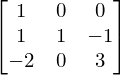

In [186]:
m = Matrix([
        [1, 0, 0],
        [1, 1, -1],
        [-2, 0, 3],
    ])
m

In [188]:
data, eigenvals, multiplicities = eigendata = eigen_data(m)
eigendata

In [197]:
m_bar = 3 # degree of \Xi minimal polynomial

In [198]:
Phi_poly = Phi_poly_ctor(deg=m_bar-1)
Phi_poly

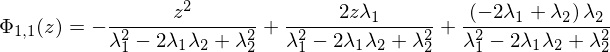

In [199]:
make = Phi_poly_define(Phi_poly, eigendata=eigendata)
make(i=1, j=1,)

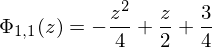

In [200]:
_.subs(eigenvals)

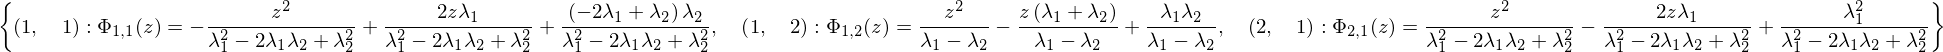

In [201]:
Phi_polynomials = component_polynomials(Phi_poly, eigendata)
Phi_polynomials

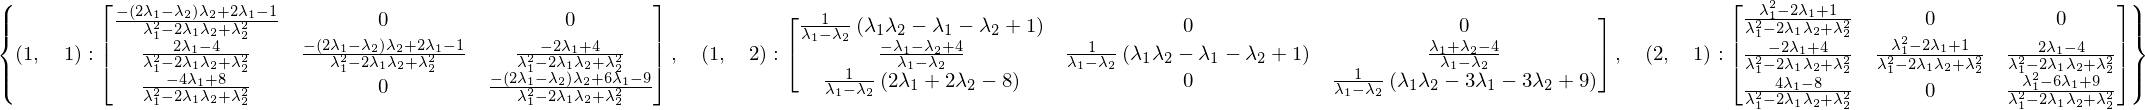

In [202]:
cmatrices = component_matrices(m, Phi_polynomials)
cmatrices

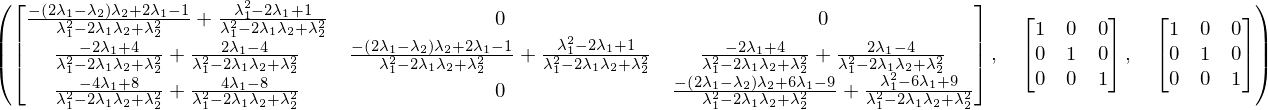

In [203]:
Zi1 = list(cm.as_immutable() for (i, j), cm in cmatrices.items() if j == 1)

s = zeros(m.rows)
for Z in Zi1:
    s += Z
s, s.simplify(), s.subs(eigenvals)

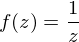

In [204]:
f, h = Function('f'), Function('h')
function_eq = Eq(f(z), 1/(z))
function_eq

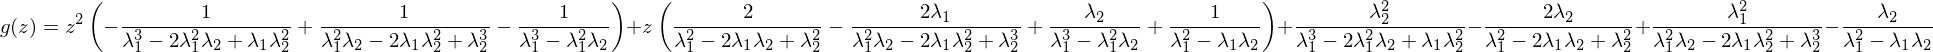

In [205]:
g = g_poly(function_eq, eigendata, Phi_polynomials)
g

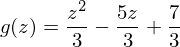

In [206]:
g = g.subs(eigenvals)
g

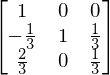

In [207]:
with lift_to_matrix_function(g) as g_inverse:
    m_inverse = g_inverse(m)
m_inverse

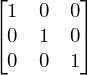

In [209]:
m_inverse*m

## an even bigger matrix

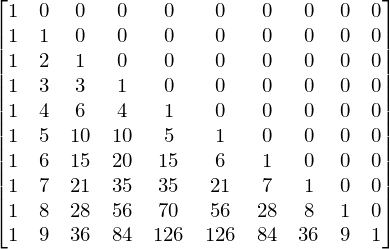

In [129]:
m = Matrix(10,10,binomial)
m

In [130]:
data, eigenvals, multiplicities = eigendata = eigen_data(m)
eigendata

In [131]:
m_bar = 10 # degree of \Xi minimal polynomial

In [132]:
Phi_poly = Phi_poly_ctor(deg=m_bar-1)
Phi_poly

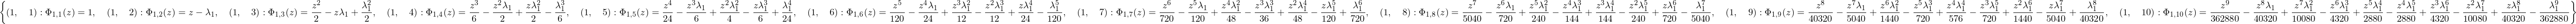

In [133]:
Phi_polynomials = component_polynomials(Phi_poly, eigendata)
Phi_polynomials

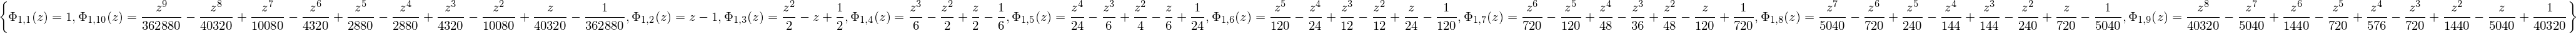

In [163]:
{v.subs(eigenvals) for k,v in Phi_polynomials.items()}

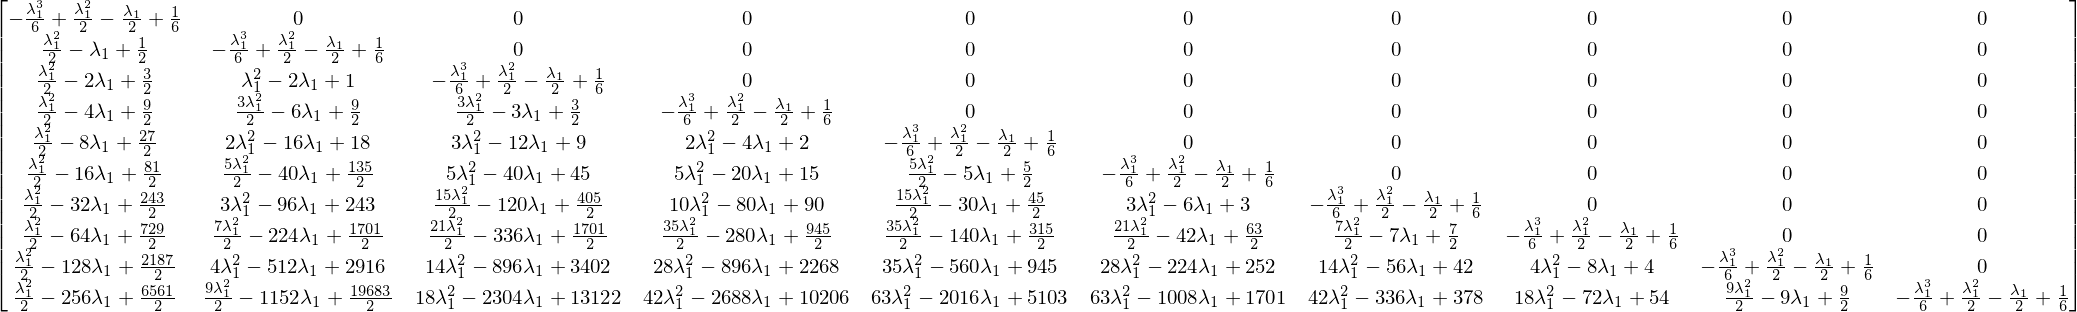

In [134]:
cmatrices = component_matrices(m, Phi_polynomials)
cmatrices[1,4]

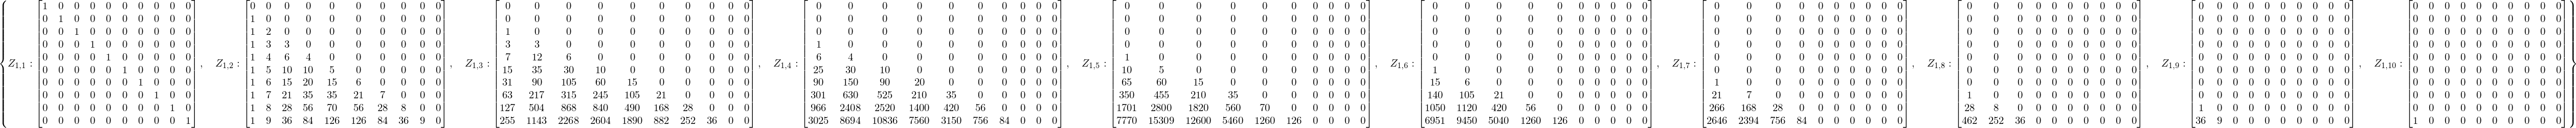

In [154]:
Z = IndexedBase('Z')
{Z[k]:v.subs(eigenvals) for k,v in cmatrices.items()}

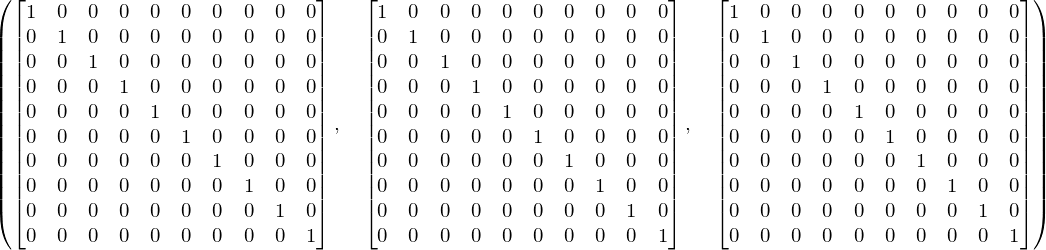

In [136]:
Zi1 = list(cm.as_immutable() for (i, j), cm in cmatrices.items() if j == 1)

s = zeros(m.rows)
for Z in Zi1:
    s += Z
s, s.simplify(), s.subs(eigenvals)

### `inverse`

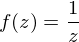

In [137]:
f, h = Function('f'), Function('h')
function_eq = Eq(f(z), 1/(z))
function_eq

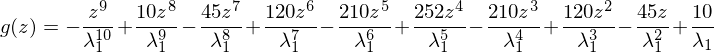

In [138]:
g = g_poly(function_eq, eigendata, Phi_polynomials)
g

In [139]:
g = g.subs(eigenvals)
g

In [146]:
sum(binomial(10, i)*(-z)**(i-1) for i in range(1, 11))

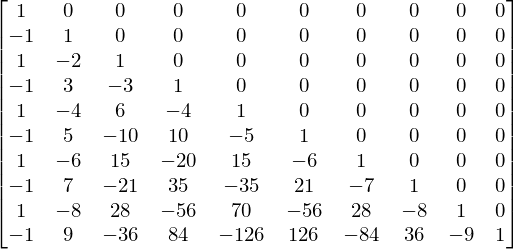

In [147]:
with lift_to_matrix_function(g) as g_inverse:
    m_inverse = g_inverse(m)
m_inverse

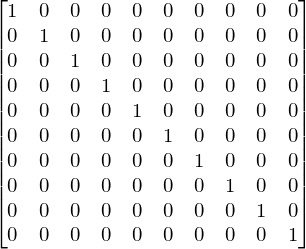

In [148]:
m_inverse*m

### `pooower`

In [155]:
f, h = Function('f'), Function('h')
function_eq = Eq(f(z), z**r)
function_eq

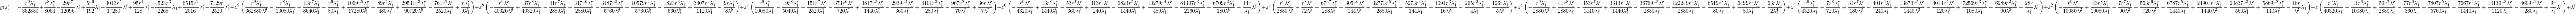

In [156]:
g = g_poly(function_eq, eigendata, Phi_polynomials)
g

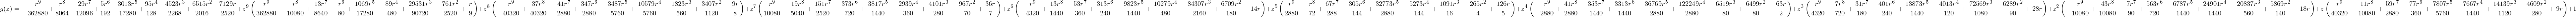

In [157]:
g = g.subs(eigenvals)
g

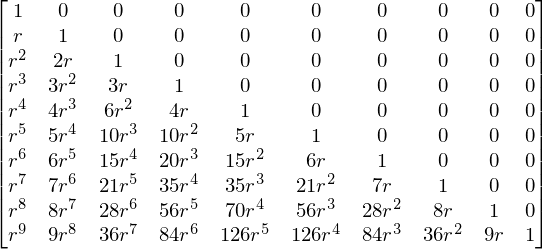

In [158]:
with lift_to_matrix_function(g) as g_power:
    m_power = g_power(m)
m_power

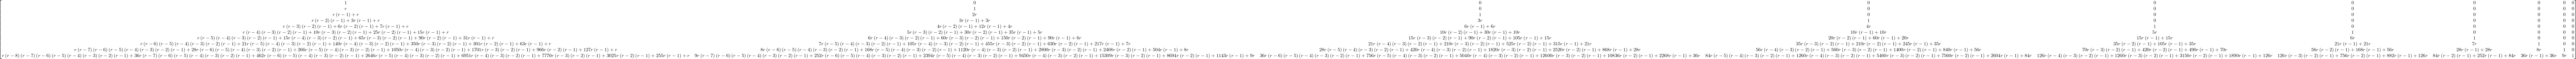

In [159]:
m**r

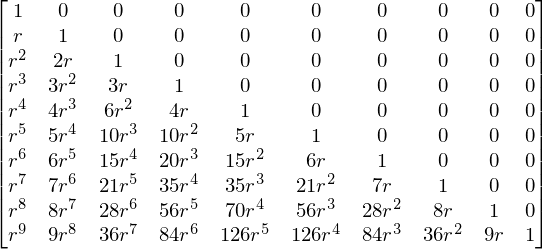

In [162]:
(m**r).applyfunc(simplify)

---

In [119]:
p = Function('p')
y, c, z = IndexedBase('y'),IndexedBase('c'), IndexedBase('z')

In [120]:
fibonacci_poly = Eq(p(z), z**2 -z -1)
fibonacci_poly

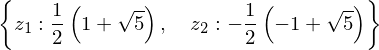

In [121]:
zs = solve(fibonacci_poly.rhs, [z])
zs ={z[i]:v for i, v in enumerate(map(factor, sorted(zs, reverse=True)), start=1)}
zs

In [122]:
solution = Eq(y[n], c[1]*z[1]**n + c[2]*z[2]**n)
solution

In [129]:
initial_conditions = {0:0, 1:1}
system = [solution.subs({n:k}).subs({y[k]:v}) for k, v in initial_conditions.items()]
system

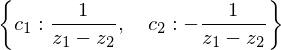

In [130]:
instantiated_sols = solve(system, [c[1],c[2]])
instantiated_sols

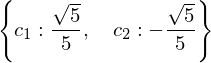

In [131]:
coeffs = {k: v.subs({z[1]:z1, z[2]:z2}).factor() for k,v in instantiated_sols.items()}
coeffs

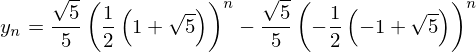

In [132]:
complete_sol = solution.subs(coeffs).subs(zs)
complete_sol

In [133]:
[complete_sol.subs(n,i).factor() for i in range(15)]